In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

## 相位噪声模拟  
时间分辨率1us，采样率1MHz，模拟时间1s  
用布朗运动模拟相位噪声

      phase speed     phase
Mean    -0.000001 -4.496571
Std      0.006161  1.758127
Var      0.000038  3.091010


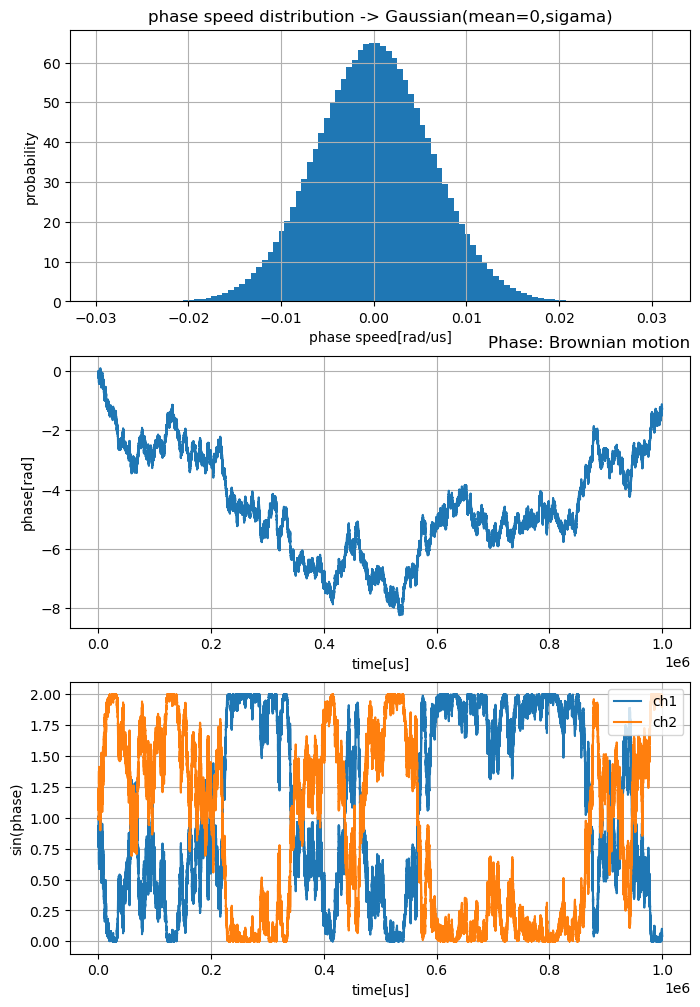

In [2]:
SIMU_TIME_RESOLUTION=0.5 #us
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.5/180*np.pi #rad/us
PHASE_SEEPD*=np.sqrt(SIMU_TIME_RESOLUTION/1) ## 将时间分辨率改变后，相位噪声标准差根号下改变
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

如果相位噪声满足独立随机分布，那么用var评估比较好，因为其关于时间（采样点）是线性的；

### method 1: 反馈1个sample  
每隔 time exposure 反馈一次  

In [3]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())

### Method 4：权重反馈

由于相位漂移速度是满足整体分布的随机变量，意味着其不具有时间相关性，每个时刻的相位速度独立同分布。因此，我们可以使用加权平均的方法来计算反馈量。具体来说，我们可以将每个时刻的相位速度乘以一个权重，然后将这些加权相位速度相加，得到最终的反馈量。这样，我们可以确保反馈量能够反映相位速度的整体分布，从而提高反馈的准确性。  
反馈的权重存在最佳估计，即反馈时间内的相位漂移量。但实际情况中往往很难估计出准确的相位漂移量，主要原因主要有两点：  
1. 测量引入的测量噪声，其中散粒噪声（shot noise）占主要成分。散粒噪声中的随机性来源于光子计数，其统计特性为泊松分布，且与信号强度成正比。因此，测量噪声的大小与信号强度成正比，信号强度越强，测量噪声越大。  
2. 测量存在测量时间，并非瞬时进行的。因此测量并不能够捕捉到相位漂移的瞬时变化，测量结果往往与实际相位漂移存在一定的偏差。  
为了解决这个问题，我们可以使用加权平均的方法来计算反馈量。具体来说，我们可以将每个时刻的相位速度乘以一个权重，然后将这些加权相位速度相加，得到最终的反馈量。这样，我们可以确保反馈量能够反映相位速度的整体分布，从而提高反馈的准确性。  
相位变化是一个维纳过程，其变化率服从高斯分布，一定时间内的相位变化服从高斯分布。我们可以考虑对于在一定置信区间内的相位变化进行全量反馈，对于超出置信区间的相位变化进行部分反馈。对于一般的高斯分布，其在3σ之外的值出现的概率为0.27%，因此我们可以将3σ之外的相位变化视为异常，进行部分反馈。

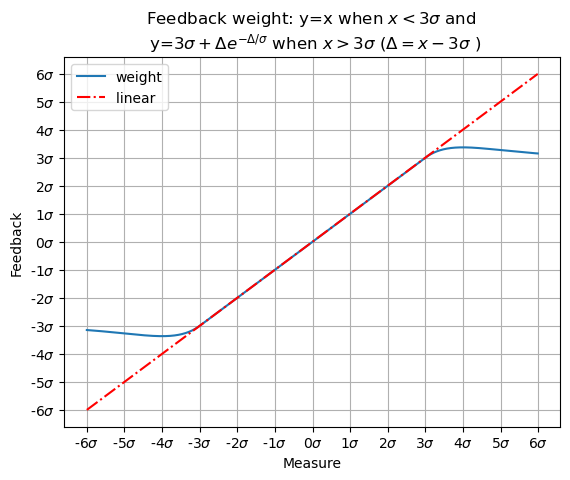

In [4]:
def fb_weight(measure, time_exposure,sigma=3,PHASE_SEEPD=PHASE_SEEPD,SIMU_TIME_RESOLUTION=SIMU_TIME_RESOLUTION):
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=sigma*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure))
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    return measure_filtered

time_exposure=2 #us
phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
x=np.arange(-2,2,1/256)*3*phase_speed_in_measure
plt.plot(x,fb_weight(x,time_exposure=time_exposure),label='weight')
plt.plot(x,x,'r-.',label='linear ')
plt.legend()
plt.grid()
plt.xticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.yticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.xlabel('Measure')
plt.ylabel('Feedback')
plt.title('Feedback weight: y=x when $x<3\sigma$ and \n y=3$\sigma+\Delta e^{-\Delta/\sigma}$ when $x>3\sigma$ ($\Delta =x-3\sigma$ )')
plt.show()

In [5]:
time_exposure=2 #us
print('离散时间间隔{}us,反馈时间对应的离散时间点{}'.format(SIMU_TIME_RESOLUTION,time_exposure/SIMU_TIME_RESOLUTION))
time_exposure=int(time_exposure/SIMU_TIME_RESOLUTION)
PHASE_SEEPD=0.5/180*np.pi #rad/us
PHASE_SEEPD*=np.sqrt(SIMU_TIME_RESOLUTION) ## 将时间分辨率改变后，相位噪声标准差根号下改变
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M4=np.zeros_like(phase_speed_M4)
phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量出的反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)
    #c0=get_phase_from_count(sig_ch1_exposure[i,-1],sig_ch2_exposure[i,-1])
    c0=phase_measure_M4[i]
    phase_fb_M4=fb_weight(c0,time_exposure=time_exposure,PHASE_SEEPD=PHASE_SEEPD,SIMU_TIME_RESOLUTION=SIMU_TIME_RESOLUTION)
    
    ##-- 反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M4[i+1,0]-=phase_fb_M4#/time_exposure # 反馈到下一个exposure

    phase_offest=phase_M4[i,-1]
phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
push_data(phase_out_M4,'phase M4 in{}us'.format(SIMU_TIME_RESOLUTION))

离散时间间隔0.5us,反馈时间对应的离散时间点4.0


  0%|          | 0/250000 [00:00<?, ?it/s]

100%|██████████| 250000/250000 [00:06<00:00, 36251.92it/s]

      phase speed     phase  phase M4 in0.5us
Mean    -0.000001 -4.496571          0.001596
Std      0.006161  1.758127          0.091627
Var      0.000038  3.091010          0.008396


In [41]:
def simu_fb(time_exposure,SIMU_TIME_RESOLUTION=SIMU_TIME_RESOLUTION,sigma=1):
    #time_exposure=1 #us
    print('离散时间间隔{}us,反馈时间对应的离散时间点{}'.format(SIMU_TIME_RESOLUTION,time_exposure/SIMU_TIME_RESOLUTION))
    time_exposure=int(time_exposure/SIMU_TIME_RESOLUTION)
    PHASE_SEEPD=0.5/180*np.pi #rad/us
    PHASE_SEEPD*=np.sqrt(SIMU_TIME_RESOLUTION) ## 将时间分辨率改变后，相位噪声标准差根号下改变
    time_axis=np.arange(0,int(1e6/SIMU_TIME_RESOLUTION),1) #1us分辨率，len=1s  SR=1M
    rng=np.random.default_rng(RAND_SEED)
    phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
    phase_speed[0]=0
    phase=np.cumsum(phase_speed)
    sig_ch1=get_sig_from_speed(phase_speed,1)
    sig_ch2=get_sig_from_speed(phase_speed,2)
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M4=np.zeros_like(phase_speed_M4)
    phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量出的反馈量
    phase_offest=0
    print('测量时间σ:{:.5e}'.format(np.sqrt(time_exposure)*PHASE_SEEPD))
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)
        #c0=get_phase_from_count(sig_ch1_exposure[i,-1],sig_ch2_exposure[i,-1])
        c0=phase_measure_M4[i]
        phase_fb_M4=fb_weight(c0,time_exposure=time_exposure,sigma=sigma,PHASE_SEEPD=PHASE_SEEPD,SIMU_TIME_RESOLUTION=SIMU_TIME_RESOLUTION)
    
        ##-- 反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            # 延时1个点反馈
            #phase_speed_M4[i+1,0]-=phase_fb_M4#/time_exposure 
            # 延时1us反馈
            phase_speed_M4[i+1,int(1/SIMU_TIME_RESOLUTION-1)]-=phase_fb_M4#/time_exposure
            

        phase_offest=phase_M4[i,-1]
    phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
    return phase_out_M4

In [26]:
time_resol_list=[0.1]
result_var=[]
for time_resol in time_resol_list:
    out=simu_fb(time_exposure=1,SIMU_TIME_RESOLUTION=time_resol,sigma=1.2)
    result_var.append(out.var())
print(np.var(out))

离散时间间隔0.1us,反馈时间对应的离散时间点10.0
测量时间σ:8.72665e-03


100%|██████████| 1000000/1000000 [00:27<00:00, 36220.77it/s]


0.0024418929142843437


In [46]:
out_100ns_2us=simu_fb(time_exposure=2,SIMU_TIME_RESOLUTION=0.1,sigma=1.2)
out_1us_2us=simu_fb(time_exposure=2,SIMU_TIME_RESOLUTION=1,sigma=1.2)
np.var(out_100ns_2us[::100]),np.var(out_1us_2us)

离散时间间隔0.1us,反馈时间对应的离散时间点20.0
测量时间σ:1.23413e-02


100%|██████████| 500000/500000 [00:14<00:00, 35654.44it/s]


离散时间间隔1us,反馈时间对应的离散时间点2.0
测量时间σ:1.23413e-02


100%|██████████| 500000/500000 [00:13<00:00, 35992.13it/s]


(0.0027535125358226806, 0.00739913481693992)

In [19]:
np.var(out_100ns_2us[::100]),np.var(out_1us_2us)

(0.0027535125358226806, 0.00739913481693992)

In [28]:
out_100ns_1us=simu_fb(time_exposure=1,SIMU_TIME_RESOLUTION=0.1,sigma=1.2)
out_100ns_500ns=simu_fb(time_exposure=0.5,SIMU_TIME_RESOLUTION=0.1,sigma=1.2)
np.var(out_100ns_1us),np.var(out_100ns_500ns)

离散时间间隔0.1us,反馈时间对应的离散时间点10.0
测量时间σ:8.72665e-03


100%|██████████| 1000000/1000000 [00:27<00:00, 36251.63it/s]


离散时间间隔0.1us,反馈时间对应的离散时间点5.0
测量时间σ:6.17067e-03


100%|██████████| 2000000/2000000 [00:55<00:00, 36286.27it/s]


(0.0024418929142843437, 0.0023258724641501438)

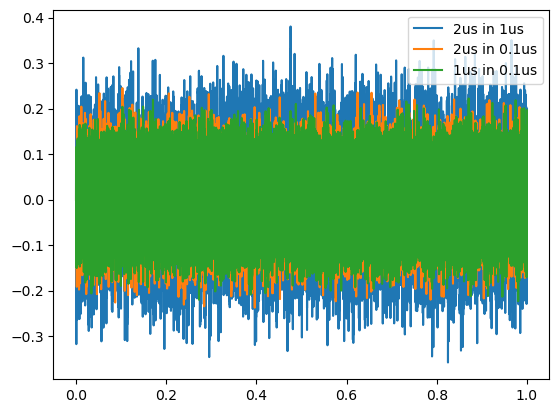

In [47]:

plt.plot(np.arange(out_1us_2us.size)*1e-6,out_1us_2us,label='2us in 1us')
plt.plot(np.arange(out_100ns_2us.size)*1e-7,out_100ns_2us,label='2us in 0.1us')
plt.plot(np.arange(out_100ns_1us.size)*1e-7,out_100ns_1us,label='1us in 0.1us')
plt.legend(loc=1)
#plt.xlim(0,1e-3)
plt.show()

In [49]:
def simu_gen(time_exposure,SIMU_TIME_RESOLUTION=SIMU_TIME_RESOLUTION,sigma=1):
    #time_exposure=1 #us
    print('离散时间间隔{}us,反馈时间对应的离散时间点{}'.format(SIMU_TIME_RESOLUTION,time_exposure/SIMU_TIME_RESOLUTION))
    time_exposure=int(time_exposure/SIMU_TIME_RESOLUTION)
    PHASE_SEEPD=0.5/180*np.pi #rad/us
    PHASE_SEEPD*=np.sqrt(SIMU_TIME_RESOLUTION) ## 将时间分辨率改变后，相位噪声标准差根号下改变
    time_axis=np.arange(0,int(1e6/SIMU_TIME_RESOLUTION),1) #1us分辨率，len=1s  SR=1M
    rng=np.random.default_rng(RAND_SEED)
    phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
    phase_speed[0]=0
    phase=np.cumsum(phase_speed)
    sig_ch1=get_sig_from_speed(phase_speed,1)
    sig_ch2=get_sig_from_speed(phase_speed,2)
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M4=np.zeros_like(phase_speed_M4)
    phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量出的反馈量
    phase_offest=0
    print('测量时间σ:{:.5e}'.format(np.sqrt(time_exposure)*PHASE_SEEPD))
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)
        #c0=get_phase_from_count(sig_ch1_exposure[i,-1],sig_ch2_exposure[i,-1])
        c0=phase_measure_M4[i]
        phase_fb_M4=c0#fb_weight(c0,time_exposure=time_exposure,sigma=sigma,PHASE_SEEPD=PHASE_SEEPD,SIMU_TIME_RESOLUTION=SIMU_TIME_RESOLUTION)
    
        ##-- 反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            # 延时1个点反馈
            #phase_speed_M4[i+1,0]-=phase_fb_M4#/time_exposure 
            # 延时1us反馈
            phase_speed_M4[i+1,int(1/SIMU_TIME_RESOLUTION-1)]-=phase_fb_M4#/time_exposure
            

        phase_offest=phase_M4[i,-1]
    phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
    return phase_out_M4

gen_100ns_100us=simu_gen(time_exposure=100,SIMU_TIME_RESOLUTION=0.1,sigma=1.2)

离散时间间隔0.1us,反馈时间对应的离散时间点1000.0
测量时间σ:8.72665e-02


100%|██████████| 10000/10000 [00:00<00:00, 34708.39it/s]


In [52]:
np.var(gen_100ns_100us)

0.006857165519857266

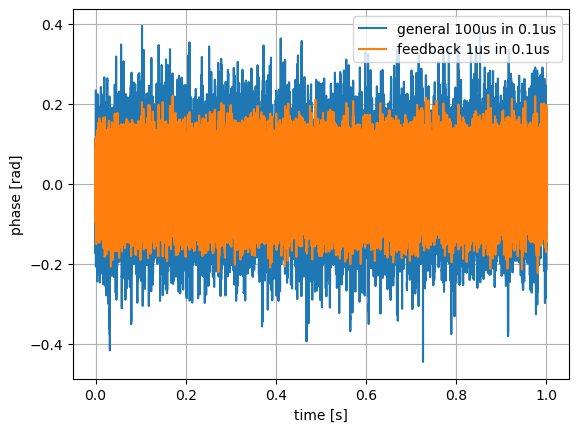

In [53]:
plt.plot(np.arange(out_100ns_2us.size)*1e-7,gen_100ns_100us,label='general 100us in 0.1us')
plt.plot(np.arange(out_100ns_1us.size)*1e-7,out_100ns_1us,label='feedback 1us in 0.1us')
plt.legend(loc=1)
#plt.xlim(0,1e-3)
plt.xlabel('time [s]')
plt.ylabel('phase [rad]')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Variance of phase with different time resolution')

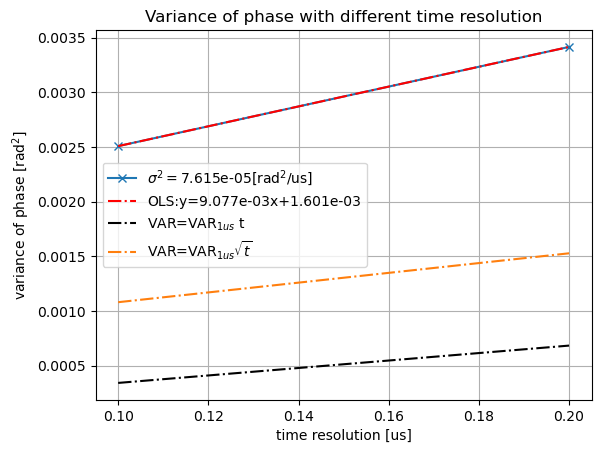

In [10]:
# 进行最小二乘拟合
p, res, _, _, _ = np.polyfit(time_resol_list, result_var, 1, full=True)

# 计算拟合值
y_fit = np.polyval(p, time_resol_list)
plt.plot(time_resol_list,np.power(result_var,1),'x-',label='$\sigma^2=${:.3e}[rad$^2$/us]'.format((0.5/180*np.pi)**2))
plt.plot(time_resol_list,y_fit,'r-.',label='OLS:y={:.3e}x+{:.3e}'.format(p[0],p[1]))
plt.plot(time_resol_list,np.array(time_resol_list)*result_var[-1],'k-.',label='VAR=VAR$_{1us}$ t')
plt.plot(time_resol_list,np.sqrt(time_resol_list)*result_var[-1],'-.',label='VAR=VAR$_{1us}\sqrt{t}$')
plt.grid()
plt.legend()
plt.xlabel('time resolution [us]')
plt.ylabel('variance of phase [rad$^2$]')
plt.title('Variance of phase with different time resolution')

In [7]:
x0=0
x1=100
# plt.plot(time_axis[x0:x1],phase[x0:x1],label='Phase')
# plt.plot(time_axis[x0:x1],np.sign(phase_out_M4[x0:x1]),label='M4')
# plt.plot(time_axis[time_exposure-1:x1:time_exposure],np.sign(phase_measure_M4[time_exposure-1:(x1+time_exposure)//time_exposure]),'x-',label='fb dirc')
# plt.legend()


fb_dirc=(np.sign(phase_measure_M4*phase_out_M4.reshape((-1,time_exposure))[:,-1]))
print('反馈方向错误:{:.2%}'.format(fb_dirc[fb_dirc<0].size/fb_dirc.size))
print('反馈方向正确:{:.2%}'.format(fb_dirc[fb_dirc>0].size/fb_dirc.size))

反馈方向错误:33.95%
反馈方向正确:52.35%


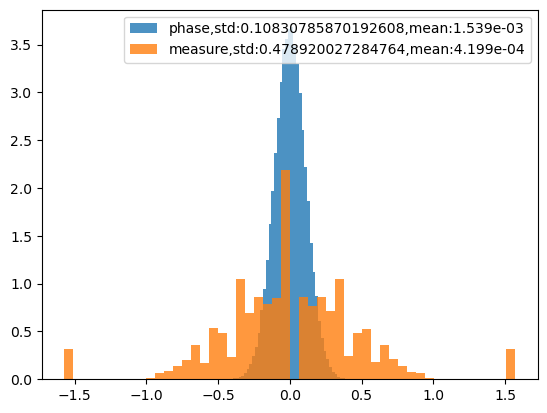

In [53]:
plt.hist(phase_out_M4[time_exposure-1::time_exposure],bins=50,density=True,alpha=0.8,label='phase,std:{},mean:{:.3e}'.format(phase_out_M4.std(),phase_out_M4.mean()))
plt.hist(phase_measure_M4,bins=50,density=True,alpha=0.8,label='measure,std:{},mean:{:.3e}'.format(phase_measure_M4.std(),phase_measure_M4.mean()))
plt.legend()

### Method 5：并行反馈

In [ ]:
time_exposure=2 #us
time_iter1=2 # iter*time_exposure 
time_iter2=3 # iter*time_exposure
time_iter3=0
time_iter4=0
print('time exposure:',time_exposure,'iter:',time_iter1*time_exposure,time_iter2*time_exposure,time_iter3*time_exposure,time_iter4*time_exposure,'us')
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M5=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M5=np.zeros_like(phase_speed_M5)
phase_measure_M5=np.zeros(phase_speed_M5.shape[0]) # 测量出的反馈量
phase_measure_it1_M5=np.zeros(phase_speed_M5.shape[0])
phase_measure_it2_M5=np.zeros(phase_speed_M5.shape[0])
phase_measure_it3_M5=np.zeros(phase_speed_M5.shape[0])
phase_measure_it4_M5=np.zeros(phase_speed_M5.shape[0])
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M5[i]=np.cumsum(phase_speed_M5[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M5[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M5[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    phase_measure_M5[i]=get_phase_from_count(ch1_measure,ch2_measure) 
    c0=fb_weight(phase_measure_M5[i],time_exposure=time_exposure)
    phase_fb_M5=c0
    
    ##-- 反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M5[i+1,0]-=phase_fb_M5#/time_exposure # 反馈到下一个exposure
    
    ##-- 迭代反馈 one 10*time_exposure
    
    if i%time_iter1==0 and i!=0:
        phaseit1=phase_M5[i,-1]+phase_speed_M5[i+1,0]
        suffix1=get_sig_from_phase(phaseit1,1)
        suffix2=get_sig_from_phase(phaseit1,2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
        ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
        phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
        phase_measure_it1_M5[i]=phase_measure_M5_it1
        c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*time_iter1)
        phase_speed_M5[i+1,1]-=c0
    
    if i%time_iter2==0 and i!=0:
        phaseit2=phase_M5[i,-1]+phase_speed_M5[i+1,:2].sum()
        suffix1=get_sig_from_phase(phaseit2,1)
        suffix2=get_sig_from_phase(phaseit2,2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter2:i+1].sum()+suffix1)
        ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter2:i+1].sum()+suffix2)
        phase_measure_M5_it2=get_phase_from_count(ch1_measure,ch2_measure)
        c0=fb_weight(phase_measure_M5_it2,time_exposure=time_exposure*time_iter2)
        phase_speed_M5[i+2,1]-=c0
    
    if i%time_iter3==0 and i!=0:
        ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter3:i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter3:i].sum())
        phase_measure_M5_it3=get_phase_from_count(ch1_measure,ch2_measure)
        c0=fb_weight(phase_measure_M5_it3,time_exposure=time_exposure*time_iter3)
        phase_speed_M5[i:i+time_iter3,0]-=c0/time_exposure#/time_iter3

    # if i%time_iter4==0 and i!=0:
    #     ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter4:i].sum())
    #     ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter4:i].sum())
    #     phase_measure_M5_it4=get_phase_from_count(ch1_measure,ch2_measure)
    #     c0=fb_weight(phase_measure_M5_it4,time_exposure=time_exposure*time_iter4)
    #     phase_speed_M5[i:i+time_iter4,0]-=c0/time_exposure#/time_iter4
    
    phase_offest=phase_M5[i,-1]
phase_out_M5=np.cumsum(phase_speed_M5.reshape(-1))
push_data(phase_out_M5,'phase M5')

time exposure: 2 iter: 4 6 0 0 us


NameError: name 'sig_ch1' is not defined

In [ ]:
phase_out_M4=simu_phase(phase_speed,time_exposure,method=4)
push_data(phase_out_M4,'phase M4')

100%|██████████| 500000/500000 [00:45<00:00, 10979.84it/s]


      phase speed     phase  phase M1  phase M2  phase M3  phase M4  phase M5
Mean    -0.000002 -6.359112  0.001449 -0.000043  0.000152 -0.000502  0.000545
Std      0.008713  2.486367  0.165383  0.176972  0.177265  0.105554  0.096527
Var      0.000076  6.182020  0.027352  0.031319  0.031423  0.011142  0.009317


In [ ]:
phase_out_M4=simu_phase(phase_speed,time_exposure*time_iter1,method=4)
push_data(phase_out_M4,'phase M4')

100%|██████████| 250000/250000 [00:15<00:00, 16383.52it/s]

      phase speed     phase  phase M1  phase M2  phase M3  phase M4  phase M5
Mean    -0.000002 -6.359112  0.001449 -0.000043  0.000152 -0.000105  0.000545
Std      0.008713  2.486367  0.165383  0.176972  0.177265  0.110837  0.096527
Var      0.000076  6.182020  0.027352  0.031319  0.031423  0.012285  0.009317


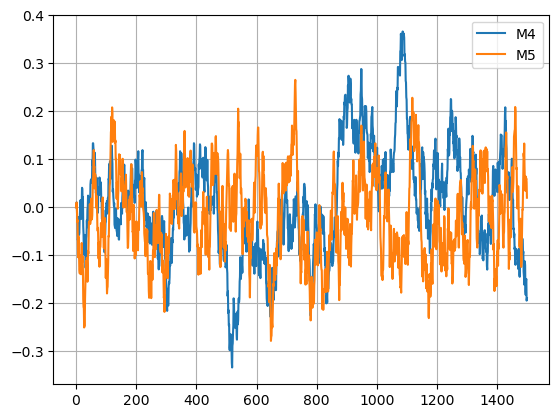

In [ ]:
x0=000
x1=1500
#plt.plot(phase[x0:x1],label='phase')
#plt.plot(phase_out_M1[x0:x1],label='M1')
# plt.plot(phase_out_M2[x0:x1],label='M2')
plt.plot(phase_out_M4[x0:x1],label='M4')
plt.plot(phase_out_M5[x0:x1],label='M5')
#plt.plot(time_axis[x0:x1][time_exposure-1::time_exposure],phase_measure_M5[x0:x1//time_exposure],'.-',label='M5_measure')
#plt.plot(time_axis[x0:x1][time_exposure-1::time_exposure],phase_measure_it1_M5[x0:x1//time_exposure],'.-',label='M5_measure_it1')
#plt.plot(time_axis[x0:x1][::time_exposure],phase_measure_M5_it2[x0:x1//time_exposure],'-',label='M5_measure_it2')
plt.legend(loc=1)
plt.grid()